In [1]:
import numpy as np
import open3d as o3d
from open3d import JVisualizer
from PIL import Image

In [2]:
import selfsupmotion.zero_shot_pose as zsp
zsp.use_cupy = False
experiment = "../output"
embeddings, info_df, train_embeddings, train_info_df = zsp.read_experiment(experiment)


In [3]:
idx=30053
points_2d, points_3d_query = zsp.get_points(info_df, idx)
points_2d_px_query = zsp.points_2d_to_points2d_px(points_2d, 360, 480)
plane_center_query, plane_normal_query= zsp.get_plane(info_df, idx)

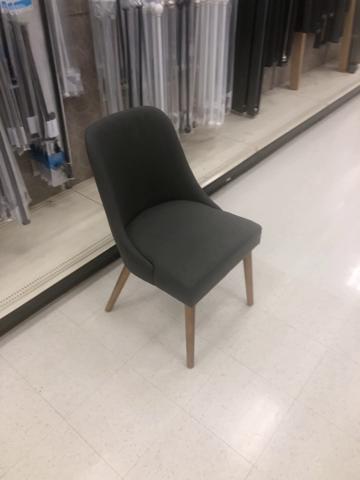

In [4]:
query_im=Image.open(info_df.iloc[idx]["filepath_full"])
query_im

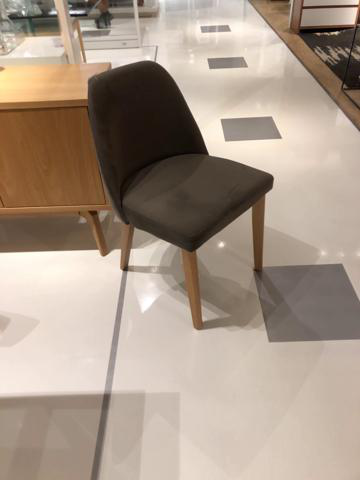

In [5]:
match_idx, score = zsp.find_match_idx(idx, embeddings, train_embeddings,0, score=True)
res_im=Image.open(train_info_df.iloc[match_idx]["filepath_full"])
res_im

In [6]:
train_info_df.iloc[match_idx]["filepath_full"], info_df.iloc[idx]["filepath_full"]

('/home/raphael/datasets/objectron/640x480_full/chair/batch-13_5_0.5.jpg',
 '/home/raphael/datasets/objectron/640x480_full/chair/batch-36_22_0.60.jpg')

In [7]:
points_2d_result, points_3d_result = zsp.get_points(train_info_df, match_idx)
points_2d_px_result = zsp.points_2d_to_points2d_px(points_2d_result, 360, 480)
plane_center_result, plane_normal_result = zsp.get_plane(train_info_df, match_idx)


In [8]:
def get_center_ajust(result_bbox, projected_center):
    cx_result = (result_bbox[0] + result_bbox[2])/2
    cy_result = (result_bbox[1] + result_bbox[3])/2
    projected_center_result = points_2d_px_result[0]
    adjust_x = projected_center_result[0] - cx_result
    adjust_y = projected_center_result[1] - cy_result
    adjust_x_rel = adjust_x / (result_bbox[2]-result_bbox[0])
    adjust_y_rel = adjust_y / (result_bbox[3]-result_bbox[1])
    return adjust_x_rel, adjust_y_rel
result_bbox = zsp.get_bbox(points_2d_px_result, 360, 480) 
projected_center = points_2d_px_result[0]
adjust_x_rel, adjust_y_rel = get_center_ajust(result_bbox, projected_center)
#adjust_x, adjust_y


#cx_result, cy_result
adjust_x_rel, adjust_y_rel

(0.020700086421208828, -0.020725156430581513)

In [9]:
query_camera = zsp.get_camera(info_df, idx)
result_bbox = zsp.get_bbox(points_2d_px_result, 360, 480)

def estimate_object_center_in_query_image(query_camera, points_2d_px_query, ):
    query_intrinsics = zsp.get_intrinsics(query_camera)
    query_intrinsics = zsp.scale_intrinsics(query_intrinsics, 0.25,0.25)
    query_bbox = zsp.get_bbox(points_2d_px_query, 360, 480)
    cx = (query_bbox[0] + query_bbox[2])/2
    cy = (query_bbox[1] + query_bbox[3])/2
    b = (cx - query_intrinsics[1,2])/query_intrinsics[1,1]
    a = (cy - query_intrinsics[0,2])/query_intrinsics[0,0]
cx, cy, a, b, points_2d_px_query[0]


NameError: name 'cx' is not defined

In [104]:
points_2d, points_3d_query = zsp.get_points(info_df, idx)
points_2d_px = zsp.points_2d_to_points2d_px(points_2d, 360, 480)
camera = zsp.get_camera(info_df, idx)
intrinsics = zsp.get_intrinsics(camera)
intrinsics = zsp.scale_intrinsics(intrinsics, 0.25,0.25)
query_bbox = zsp.get_bbox(points_2d_px, 360, 480)
cx = (query_bbox[0] + query_bbox[2])/2 
cy = (query_bbox[1] + query_bbox[3])/2 

In [109]:
adjust_x_px = adjust_x_rel * (query_bbox[2]-query_bbox[0])
adjust_y_px = adjust_y_rel * (query_bbox[3]-query_bbox[1])
adjust_x_px, adjust_y_px

(4.914777329825884, -6.04991717348051)

In [111]:
cx = cx + adjust_x_px
cy = cy + adjust_y_px

In [112]:
b = (cx - intrinsics[1,2])/intrinsics[1,1]
a = (cy - intrinsics[0,2])/intrinsics[0,0]

In [113]:
query_center_ray = np.array([a,b,-1])

In [116]:
box_rotation = zsp.rotation_matrix_from_vectors(plane_normal_query, plane_normal_result)
plane_normal_query, plane_normal_result, plane_center_query, plane_center_result
points_3d_axis = np.dot(points_3d_result-points_3d_result[0],box_rotation)+points_3d_result[0]


In [117]:
z=-points_3d_query[0][2]
#az = x, bz = y
point_on_center_line = np.array([a,b,-1])
point_on_center_line

def get_dist_from_plane(plane_normal, plane_center, point):
    plane = zsp.get_plane_equation_center_normal(plane_center, plane_normal)
    a, b, c, d = plane
    X,Y,Z = point
    return abs(a*X + b*Y + c*Z + d)/np.sqrt(a**2+b**2+c**2)
obj_radius = get_dist_from_plane(plane_normal_result, plane_center_result, points_3d_result[0])
obj_radius


0.39000092642070106

In [118]:
obj_radius = get_dist_from_plane(plane_normal_result, plane_center_result, points_3d_axis[0])
obj_radius

0.39000092642070106

In [119]:

def intersect_plane_with_line(plane_normal, plane_center, point1, point0=np.array([0,0,0])):
    p0 = plane_center
    n = plane_normal
    l0 = point0 #Line start.
    l = point1 #Line end
    d = np.dot((p0-l0), n)/np.dot(l,n)
    intersect = l0 + d*l
    return intersect
offset = obj_radius * plane_normal_query
#offset = np.array([0,0,0])
new_center = intersect_plane_with_line(plane_normal_query, plane_center_query+offset, point_on_center_line) 
new_center, offset, points_3d_query[0], points_3d_result[0]


(array([-0.01902001, -0.04408974, -1.63486581]),
 array([-3.10594720e-01,  3.08943797e-07,  2.35863605e-01]),
 array([-0.01121233, -0.05092812, -1.55569029]),
 array([-0.16948791,  0.0199213 , -1.44566977]))

In [121]:
get_dist_from_plane(plane_normal_query, plane_center_query, new_center)
points_3d_result_centered = points_3d_axis - points_3d_axis[0] + new_center
points_3d_result_centered

array([[-0.01902001, -0.04408974, -1.63486581],
       [ 0.29753165, -0.42948306, -1.86288312],
       [ 0.52397083, -0.01305471, -1.56470155],
       [-0.32365543, -0.42948227, -1.39115642],
       [-0.09721722, -0.01305387, -1.09297487],
       [ 0.05917721, -0.07512564, -2.1767577 ],
       [ 0.28561543,  0.34130277, -1.87857627],
       [-0.56200987, -0.07512484, -1.705031  ],
       [-0.33557166,  0.34130356, -1.40684957]])

In [124]:
def snap_to_plane(points3d, plane_normal, plane_center, obj_radius=None):
    if obj_radius is None:
        obj_radius = get_dist_from_plane(plane_normal_result, plane_center_result, points3d[0])
    offset = obj_radius * plane_normal_query
    new_center = intersect_plane_with_line(plane_normal_query, plane_center_query+offset, point_on_center_line) 
    snapped = points3d - points3d[0] + new_center
    return snapped
points_3d_result_centered_px = snap_to_plane(points_3d_axis, plane_normal_query+offset, plane_center_query+offset)
points_3d_result_centered_px

array([[-0.01902001, -0.04408974, -1.63486581],
       [ 0.29753165, -0.42948306, -1.86288312],
       [ 0.52397083, -0.01305471, -1.56470155],
       [-0.32365543, -0.42948227, -1.39115642],
       [-0.09721722, -0.01305387, -1.09297487],
       [ 0.05917721, -0.07512564, -2.1767577 ],
       [ 0.28561543,  0.34130277, -1.87857627],
       [-0.56200987, -0.07512484, -1.705031  ],
       [-0.33557166,  0.34130356, -1.40684957]])

In [138]:
import pandas as pd
def build_df(points_3d, name="default"):
    df = pd.DataFrame(points_3d).rename(columns={0:"x", 1:"y", 2:"z"})
    df["name"]=name
    df = df.append(pd.Series([0,0,0,"camera"], index=df.columns ), ignore_index=True)
    return df

In [139]:
points3d_df = build_df(points_3d_query, "query")
points3d_df = points3d_df.append(build_df(points_3d_result_centered, "result"))
#points3d_df = points3d_df.append(build_df(points_3d_result_centered_px, "transformed"))


In [140]:
plane_center_query,plane_normal_query

(array([ 0.33256465, -0.05092859, -1.8167522 ]),
 array([-7.96394825e-01,  7.92161700e-07,  6.04777038e-01]))

In [141]:
points_3d_query

array([[-0.01121233, -0.05092812, -1.55569029],
       [ 0.34220463, -0.44023991, -1.80405712],
       [ 0.56467259,  0.01631761, -1.51110339],
       [-0.34534937, -0.44023895, -1.28193319],
       [-0.12288152,  0.01631856, -0.98897934],
       [ 0.10045679, -0.11817479, -2.12240124],
       [ 0.32292467,  0.33838284, -1.82944751],
       [-0.58709723, -0.11817384, -1.60027719],
       [-0.36462945,  0.33838379, -1.30732346]])

In [142]:
import plotly.express as px
import plotly.express as px
#df = points3d_result
fig = px.scatter_3d(points3d_df, x="x", y="y", z="z", color="name")
fig.show()


In [143]:
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points_3d_result_centered))

0.6524187577015098

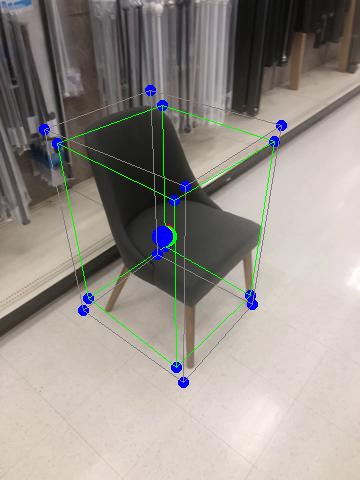

In [145]:
query_im=Image.open(info_df.iloc[idx]["filepath_full"])
points2d_px_result = zsp.project_3d_to_2d(points_3d_result_centered, intrinsics)
points2d_px_query = zsp.project_3d_to_2d(points_3d_query, intrinsics)
zsp.draw_bbox(query_im,points2d_px_result)
zsp.draw_bbox(query_im,points2d_px_query, line_color=(128,128,128), pixel_center_color=(0,0,255),object_center_color=(255,255,0))

In [133]:
result_bbox = zsp.get_bbox(points2d_px_result, query_im.width, query_im.height)
query_bbox = zsp.get_bbox(points2d_px_query, query_im.width, query_im.height)

In [85]:
def get_bbox_area(bbox):
    dx = bbox[2]-bbox[0]
    dy = bbox[3]-bbox[1]
    return np.sqrt(dx**2+dy**2)
scale = get_bbox_area(query_bbox) / get_bbox_area(result_bbox)
scale

1.1055183682457537

In [86]:
def get_scale_factor(points_3d_query, points3d_scaled):
    points2d_px_result = zsp.project_3d_to_2d(points3d_scaled, intrinsics)
    points2d_px_query = zsp.project_3d_to_2d(points_3d_query, intrinsics)
    result_bbox = zsp.get_bbox(points2d_px_result, query_im.width, query_im.height)
    query_bbox = zsp.get_bbox(points2d_px_query, query_im.width, query_im.height)
    scale = get_bbox_area(query_bbox) / get_bbox_area(result_bbox)
    return scale

In [87]:
def get_smooth_scale_factor(points_3d_query, points3d_scaled, alpha):
    factor = get_scale_factor(points_3d_query, points3d_scaled)    
    return (alpha+factor-1)/alpha

In [88]:
scale = get_smooth_scale_factor(points_3d_query, points_3d_result_centered, 2)
scale

1.052759184122877

In [89]:
def scale_3d_bbox(bbox, factor):
    assert factor>0
    #factor_a = (1+factor)/2
    #factor_b = (1+factor)/2
    center = bbox[0]
    bbox = (bbox-center)*factor + center #/factor_b
    return bbox

In [90]:
points3d_scaled = snap_to_plane(scale_3d_bbox(points_3d_result_centered, scale), plane_normal_query, plane_center_query, obj_radius = obj_radius*scale)
points3d_scaled

array([[-0.01861803, -0.04315793, -1.6003138 ],
       [ 0.31463464, -0.44888429, -1.84036112],
       [ 0.55302056, -0.01048551, -1.52644773],
       [-0.33932577, -0.44888345, -1.3437465 ],
       [-0.10094086, -0.01048463, -1.02983313],
       [ 0.06370481, -0.07583126, -2.17079547],
       [ 0.30208973,  0.36256757, -1.85688223],
       [-0.5902556 , -0.07583041, -1.67418085],
       [-0.35187069,  0.36256841, -1.36026761]])

In [92]:
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled))

0.7854928286905482

In [93]:

get_scale_factor(points_3d_query, points3d_scaled)

1.0223474875529222

In [94]:

get_smooth_scale_factor(points_3d_query, points3d_scaled, 3)

1.0074491625176407

In [51]:
scale = get_smooth_scale_factor(points_3d_query, points3d_scaled, 2)
for i in range(0,3):
    obj_radius = get_dist_from_plane(plane_normal_query, plane_center_query, points3d_scaled[0])
    points3d_scaled = snap_to_plane(scale_3d_bbox(points3d_scaled, scale), plane_normal_query, plane_center_query, obj_radius = obj_radius*scale)
#    points3d_scaled = snap_to_plane_px(scale_3d_bbox(points_3d_result_centered, scale), plane_normal_query, plane_center_query, plane_normal_result, plane_center_result, obj_radius = obj_radius*scale)
    scale = get_smooth_scale_factor(points_3d_query, points3d_scaled, 2)
    print(i, obj_radius, scale, zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled)))
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled))

0 0.4105770536298955 1.0024547594836464 0.8131235878161949
1 0.4151647329128834 1.0005435165262058 0.8180783930713781
2 0.416183858954882 1.0001205503349218 0.8191050178889032


0.8191050178889032

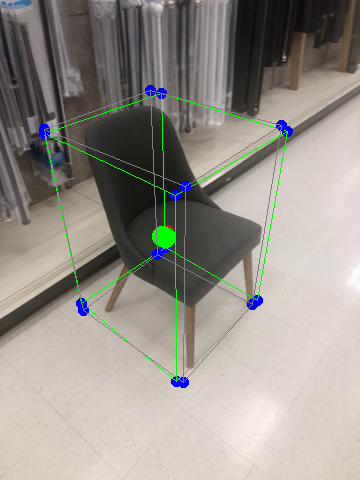

In [52]:
query_im=Image.open(info_df.iloc[idx]["filepath_full"])
points2d_px_result = zsp.project_3d_to_2d(points3d_scaled, intrinsics)
points2d_px_query = zsp.project_3d_to_2d(points_3d_query, intrinsics)
zsp.draw_bbox(query_im,points2d_px_result)
zsp.draw_bbox(query_im,points2d_px_query, line_color=(128,128,128))

In [55]:
points3d_df = build_df(points_3d_query, "query")
#points3d_df = points3d_df.append(build_df(points_3d_result, "result"))
points3d_df = points3d_df.append(build_df(points3d_scaled, "points3d_scaled"))
fig = px.scatter_3d(points3d_df, x="x", y="y", z="z", color="name")
fig.show()